# Setup

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal
from matplotlib.colors import LogNorm
from sklearn.cluster import DBSCAN
import scipy
import seaborn as sns
from sklearn.neighbors import NearestNeighbors # importing the library
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
earth_density    = 5.51   # [g/cm**3]

In [2]:
dataEA = pd.read_csv(r"C:\Users\silke\OneDrive\Skrivebord\Thesis\Exoplanet_Archive.csv",delimiter=",")
dataLI = pd.read_csv(r"C:\Users\silke\OneDrive\Skrivebord\Thesis\STPM_improved_210721.csv",delimiter=",")
planet_name_LI        = list(dataLI["Star"]+" "+dataLI["Planet"])
dataLI["planet_name"] = planet_name_LI
LIV34_planets = ["K2-146 b",'TRAPPIST-1 h', 'TRAPPIST-1 d', 'TRAPPIST-1 e', 'TRAPPIST-1 f', 'TRAPPIST-1 g', 'TRAPPIST-1 c', 'TRAPPIST-1 b', 'GJ 1132 b', 'TOI-270 b', 'GJ 3053 c', 'GJ 1252 b', 'GJ 357 b', 'LTT 3780 b', 'LHS 1478 b', 'GJ 486 b', 'GJ 3473 b', 'CD-60 8051 b', 'L 98-59 c', 'L 98-59 d', 'GJ 3053 b', 'TOI-270 d', 'TOI-776 b', 'TOI-1634 b', 'TOI-1685 b', 'TOI-1235 b', 'K2-146 c', 'LTT 3780 c', 'TOI-270 c', 'K2-18 b', 'TOI-269 b', 'GJ 1214 b', 'K2-25 b', 'TOI-1231 b']

In [3]:
# Exoplanet Archive
planet_name_EA       = dataEA.pl_name
planet_id_EA         = list(range(0,len(planet_name_EA)))

disc_year_EA         = dataEA.disc_year
st_spectype_EA       = dataEA.st_spectype        # Spectral type of star
pl_eq_EA             = dataEA.pl_eqt             # [K] Equilibrium Temperature

period               = dataEA.pl_orbper            # [days]
period_unc_up        = dataEA.pl_orbpererr1
period_unc_low       = dataEA.pl_orbpererr2

period_EA            = dataEA.pl_orbper          # [days]
radius_EA            = dataEA.pl_rade            # [Earth Radius]
radius_unc_up_EA     = dataEA.pl_radeerr1        # [Earth Radius] Upper Unc.
radius_unc_low_EA    = dataEA.pl_radeerr2        # [Earth Radius] Lower Unc.

mass_EA              = dataEA.pl_bmasse          # [Earth Mass] - Planet Mass or Mass*sin(i) [Earth Mass]
mass_unc_up_EA       = dataEA.pl_bmasseerr1      # [Earth Mass] Upper Unc.
mass_unc_low_EA      = dataEA.pl_bmasseerr2      # [Earth Mass] Lower Unc.

density_EA           = dataEA.pl_dens            # [g/cm**3]
density_unc_up_EA    = dataEA.pl_denserr1        # [g/cm**3] Planet Density Upper Unc. 
density_unc_low_EA   = dataEA.pl_denserr2        # [g/cm**3] Planet Density Lower Unc. 

# Luque Data
planet_name_LI        = list(dataLI["Star"]+" "+dataLI["Planet"])
planet_id_LI         = dataLI.ID
star_name_LI         = dataLI.Star
planet_letter_LI     = dataLI.Planet

radius_LI            = dataLI.R_Rterra            # [Earth Radius]
radius_unc_up_LI     = dataLI.euR_Rterra          # [Earth Radius] Upper Unc.
radius_unc_low_LI    = dataLI.edR_Rterra          # [Earth Radius] Lower Unc.

mass_LI              = dataLI.M_Mterra            # [Earth Mass] - Planet Mass or Mass*sin(i) [Earth Mass]
mass_unc_up_LI       = dataLI.euM_Mterra          # [Earth Mass] Upper Unc.
mass_unc_low_LI      = dataLI.edM_Mterra          # [Earth Mass] Lower Unc.

density_LI           = dataLI[dataLI.columns[32]]  # [g/cm**3]
density_unc_up_LI    = dataLI[dataLI.columns[33]]  # [g/cm**3] Planet Density Upper Unc. 
density_unc_low_LI   = dataLI[dataLI.columns[34]]  # [g/cm**3] Planet Density Lower Unc

pl_eq_LI             = dataLI.Teq_K                # [K] Equilibrium Temperature

##### Use the Luque values for planets in that sample #### 
for i in range(0,len(planet_name_EA)):
    if planet_name_EA[i] in planet_name_LI:
        LI_index              = planet_name_LI.index(planet_name_EA[i])
       
        mass_EA[i]            = mass_LI[LI_index]
        mass_unc_up_EA[i]     = mass_unc_up_LI[LI_index]
        mass_unc_low_EA[i]    = mass_unc_low_LI[LI_index]
        
        radius_EA[i]          = radius_LI[LI_index]
        radius_unc_up_EA[i]   = radius_unc_up_LI[LI_index]      
        radius_unc_low_EA[i]  = radius_unc_low_LI[LI_index]    

        density_EA[i]         = density_LI[LI_index]  
        density_unc_up_EA[i]  = density_unc_up_LI[LI_index]  
        density_unc_low_EA[i] = density_unc_low_LI[LI_index] 
        

# Filter Planets

In [4]:
def filter_planets(planet_name_list,rel_unc_mass_criteria,rel_unc_density_criteria,star_type):
    EA_planets = []
    for i in range(0,len(planet_name_list)):
        if radius_EA[i]<4 and isinstance(st_spectype_EA[i],str) and star_type in st_spectype_EA[i]:
            relative_uncertainty_mass    = (mass_unc_up_EA[i] - mass_unc_low_EA[i]) / (2 * mass_EA[i])
            relative_uncertainty_density = (density_unc_up_EA[i] - density_unc_low_EA[i]) / (2 * density_EA[i])
            if relative_uncertainty_mass < rel_unc_mass_criteria and relative_uncertainty_density < rel_unc_density_criteria:
                EA_planets.append(planet_name_list[i])
    if rel_unc_mass_criteria > 0.06 and rel_unc_density_criteria > 0.06 and "M" in star_type:
    #### Adding the TRAPPIST-1 planets  ##### (biggest rel_err around 6%)
        EA_add_index = [5209,5210,5211,5212,5213,5214,5215] # adding the Trappist Planets
        for i in EA_add_index:
            EA_planets.append(planet_name_EA[i])
    return EA_planets

def filter_planets_no_unc(planet_name_list,star_type):
    L_planets = []
    EA_planets = []
    if len(planet_name_list) == 48:
        for i in range(0,len(planet_name_list)):
            if planet_name_list[i] in LIV34_planets:
                L_planets.append(planet_name_list[i])
        return L_planets
    else:
        for i in range(0,len(planet_name_list)):
            if radius_EA[i]<4 and isinstance(st_spectype_EA[i],str) and star_type in st_spectype_EA[i]:
                EA_planets.append(planet_name_list[i])
        if "M" in star_type:
        #### Adding the TRAPPIST-1 planets  ##### (biggest rel_err around 6%)
            EA_add_index = [5209,5210,5211,5212,5213,5214,5215] # adding the Trappist Planets
            for i in EA_add_index:
                EA_planets.append(planet_name_EA[i])
        return EA_planets

def filter_planets_radii(planet_name_list,star_type,radius_criteria):
    EA_planets = []
    for i in range(0,len(planet_name_list)):
        if radius_EA[i]<radius_criteria and isinstance(st_spectype_EA[i],str) and star_type in st_spectype_EA[i]:
            EA_planets.append(planet_name_list[i])
    if "M" in star_type:
    #### Adding the TRAPPIST-1 planets  ##### (biggest rel_err around 6%)
        EA_add_index = [5209,5210,5211,5212,5213,5214,5215] # adding the Trappist Planets
        for i in range(0,len(EA_add_index)):
            if radius_EA[EA_add_index[i]] < radius_criteria:
                EA_planets.append(planet_name_EA[EA_add_index[i]])
    return EA_planets

In [5]:
def make_lists(EA_planets):
    planet      = [];planet_i       = []; disc_year   = []
    radius      = []; radius_up     = []; radius_low  = []
    mass        = [];  mass_up      = []; mass_low    = []
    density     = []; density_up    = []; density_low = []

    for i in range(0,len(EA_planets)):
        index  = list(planet_name_EA).index(EA_planets[i]); planet.append(dataEA.pl_name[index])
        radius.append(dataEA.pl_rade[index]); radius_up.append(dataEA.pl_radeerr1[index]); radius_low.append(dataEA.pl_radeerr2[index])
        density.append(dataEA.pl_dens[index]); density_up.append(dataEA.pl_denserr1[index]); density_low.append(dataEA.pl_denserr2[index])
        mass.append(dataEA.pl_bmasse[index]); mass_up.append(dataEA.pl_bmasseerr1[index]);  mass_low.append(dataEA.pl_bmasseerr2[index])
        disc_year.append(disc_year_EA[index])
    return index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low, disc_year

def find_planet_index(name):
    return (list(EA_planets).index(name))

In [6]:
EA_planets = filter_planets(planet_name_EA,0.20,0.20,"M")
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low, disc_year= make_lists(EA_planets)
mass_err         = [np.abs(mass_low),mass_up]
density_err      = [np.divide(np.abs(density_low),earth_density),np.divide(density_up,earth_density)]


## MGK-types mass-density and mass-radius

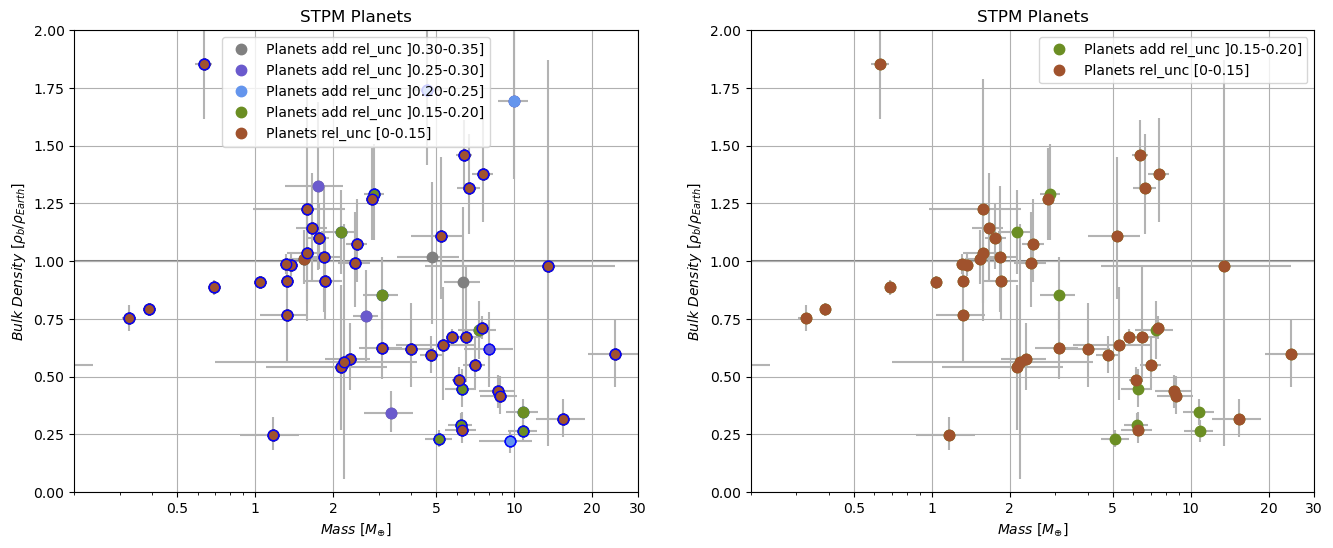

In [7]:
plt.figure(figsize=(16, 6))
markersize = 15
plt.subplot(1, 2, 1)
EA_planets = filter_planets(planet_name_EA,0.35,0.35,"M")
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low,disc_year = make_lists(EA_planets)
mass_err         = [np.abs(mass_low),mass_up]
density_err      = [np.divide(np.abs(density_low),earth_density),np.divide(density_up,earth_density)]
plt.errorbar(mass,np.divide(density,earth_density),xerr = mass_err, yerr = density_err,fmt=".",color="0.7",zorder=-18)
plt.plot(mass,np.divide(density,earth_density),".",label = "Planets add rel_unc ]0.30-0.35]",color = "grey",markersize = markersize)
for i in range(0,len(EA_planets)):
    if disc_year[i] <= 2021:
        plt.plot(mass[i],np.divide(density[i],earth_density),".",color = "grey",markersize = markersize,mec = "blue")

EA_planets = filter_planets(planet_name_EA,0.30,0.30,"M")
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low,disc_year = make_lists(EA_planets)
plt.plot(mass,np.divide(density,earth_density),".",label = "Planets add rel_unc ]0.25-0.30]",color = "slateblue",markersize = markersize)
for i in range(0,len(EA_planets)):
    if disc_year[i] <= 2021:
        plt.plot(mass[i],np.divide(density[i],earth_density),".",color = "slateblue",markersize = markersize,mec = "blue")

EA_planets = filter_planets(planet_name_EA,0.25,0.25,"M")
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low,disc_year = make_lists(EA_planets)
mass_err         = [np.abs(mass_low),mass_up]
density_err      = [np.divide(np.abs(density_low),earth_density),np.divide(density_up,earth_density)]
plt.plot(mass,np.divide(density,earth_density),".",label = "Planets add rel_unc ]0.20-0.25]",color = "cornflowerblue",markersize = markersize)
for i in range(0,len(EA_planets)):
    if disc_year[i] <= 2021:
        plt.plot(mass[i],np.divide(density[i],earth_density),".",color = "cornflowerblue",markersize = markersize,mec = "blue")


EA_planets = filter_planets(planet_name_EA,0.20,0.20,"M")
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low,disc_year = make_lists(EA_planets)
mass_err         = [np.abs(mass_low),mass_up]
density_err      = [np.divide(np.abs(density_low),earth_density),np.divide(density_up,earth_density)]
plt.plot(mass,np.divide(density,earth_density),".",label = "Planets add rel_unc ]0.15-0.20]",color = "olivedrab",markersize = markersize)
for i in range(0,len(EA_planets)):
    if disc_year[i] <= 2021:
        plt.plot(mass[i],np.divide(density[i],earth_density),".",color = "olivedrab",markersize = markersize,mec = "blue")


EA_planets = filter_planets(planet_name_EA,0.15,0.15,"M")
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low,disc_year = make_lists(EA_planets)
mass_err         = [np.abs(mass_low),mass_up]
density_err      = [np.divide(np.abs(density_low),earth_density),np.divide(density_up,earth_density)]
plt.plot(mass,np.divide(density,earth_density),".",label = "Planets rel_unc [0-0.15]",color = "Sienna",markersize = markersize)
for i in range(0,len(EA_planets)):
    if disc_year[i] <= 2021:
        plt.plot(mass[i],np.divide(density[i],earth_density),".",color = "Sienna",markersize = markersize,mec = "blue")

# Formatting
plt.xlabel("$Mass\ [M_{\oplus}]$"); plt.ylabel("$Bulk\ Density\ [ρ_{b}/ρ_{Earth}]$"); plt.xscale("log"); plt.title("STPM Planets"); plt.ylim(0,2); plt.xlim(0.2,30); plt.xticks([0.5,1,2,5,10,20, 30],["0.5","1","2","5","10","20", "30"],minor=False); leg = plt.legend(); plt.hlines(1,0,30,"grey",zorder = -30); plt.grid()

plt.subplot(1, 2, 2)

EA_planets = filter_planets(planet_name_EA,0.20,0.20,"M")
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low,disc_year = make_lists(EA_planets)
mass_err   = [np.abs(mass_low),mass_up]; density_err = [np.divide(np.abs(density_low),earth_density),np.divide(density_up,earth_density)]
plt.errorbar(mass,np.divide(density,earth_density),xerr = mass_err, yerr = density_err,fmt=".",color="0.7",zorder=-18)
plt.plot(mass,np.divide(density,earth_density),".",label = "Planets add rel_unc ]0.15-0.20]",color = "olivedrab",markersize = markersize)

EA_planets = filter_planets(planet_name_EA,0.15,0.15,"M")
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low,disc_year = make_lists(EA_planets)
mass_err   = [np.abs(mass_low),mass_up]; density_err = [np.divide(np.abs(density_low),earth_density),np.divide(density_up,earth_density)]
plt.plot(mass,np.divide(density,earth_density),".",label = "Planets rel_unc [0-0.15]",color = "Sienna",markersize = markersize)
plt.xlabel("$Mass\ [M_{\oplus}]$"); plt.ylabel("$Bulk\ Density\ [ρ_{b}/ρ_{Earth}]$"); plt.xscale("log"); plt.title("STPM Planets"); plt.ylim(0,2); plt.xlim(0.2,30); plt.xticks([0.5,1,2,5,10,20, 30],["0.5","1","2","5","10","20", "30"],minor=False); leg = plt.legend(); plt.hlines(1,0,30,"grey",zorder = -30); plt.grid()

## M types and their discovery year

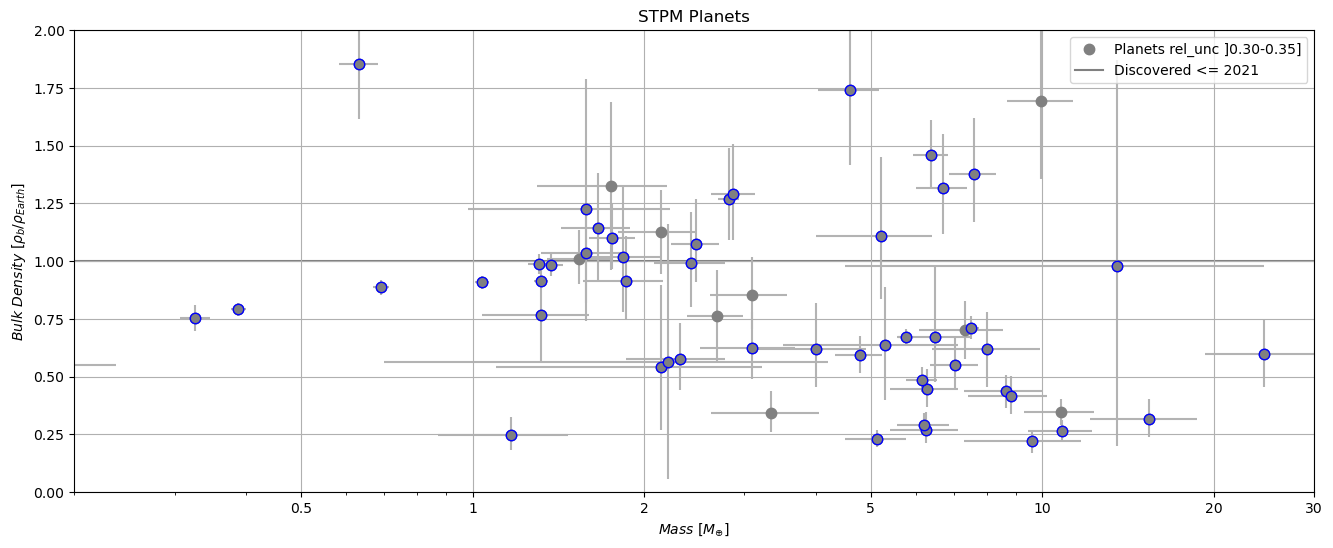

In [8]:
plt.figure(figsize=(16, 6))
markersize = 15
EA_planets = filter_planets(planet_name_EA,0.30,0.30,"M")
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low,disc_year = make_lists(EA_planets)
mass_err         = [np.abs(mass_low),mass_up]
density_err      = [np.divide(np.abs(density_low),earth_density),np.divide(density_up,earth_density)]
plt.errorbar(mass,np.divide(density,earth_density),xerr = mass_err, yerr = density_err,fmt=".",color="0.7",zorder=-18)
plt.plot(mass,np.divide(density,earth_density),".",label = "Planets rel_unc ]0.30-0.35]",color = "grey",markersize = markersize)
for i in range(0,len(EA_planets)):
    if disc_year[i] <= 2021:
        plt.plot(mass[i],np.divide(density[i],earth_density),".",color = "grey",markersize = markersize,mec = "blue")
plt.plot(100,100,color = "grey", markersize = markersize,mec = "blue", label = "Discovered <= 2021")
plt.xlabel("$Mass\ [M_{\oplus}]$"); plt.ylabel("$Bulk\ Density\ [ρ_{b}/ρ_{Earth}]$"); plt.xscale("log"); plt.title("STPM Planets"); plt.ylim(0,2); plt.xlim(0.2,30); plt.xticks([0.5,1,2,5,10,20, 30],["0.5","1","2","5","10","20", "30"],minor=False); leg = plt.legend(); plt.hlines(1,0,30,"grey",zorder = -30); plt.grid()

In [9]:
disc_year_EA

def filter_planets_2021less(planet_name_list,star_type):
    EA_planets = []
    for i in range(0,len(planet_name_list)):
        if radius_EA[i]<4 and isinstance(st_spectype_EA[i],str) and star_type in st_spectype_EA[i] and disc_year_EA[i] <= 2021:
            EA_planets.append(planet_name_list[i])
    if "M" in star_type:
    #### Adding the TRAPPIST-1 planets  ##### (biggest rel_err around 6%)
        EA_add_index = [5209,5210,5211,5212,5213,5214,5215] # adding the Trappist Planets
        for i in EA_add_index:
            EA_planets.append(planet_name_EA[i])
    return EA_planets

def filter_planets_2022(planet_name_list,star_type):
    EA_planets = []
    for i in range(0,len(planet_name_list)):
        if radius_EA[i]<4 and isinstance(st_spectype_EA[i],str) and star_type in st_spectype_EA[i] and disc_year_EA[i] > 2021:
            EA_planets.append(planet_name_list[i])
    if "M" in star_type:
    #### Adding the TRAPPIST-1 planets  ##### (biggest rel_err around 6%)
        EA_add_index = [5209,5210,5211,5212,5213,5214,5215] # adding the Trappist Planets
        for i in EA_add_index:
            EA_planets.append(planet_name_EA[i])
    return EA_planets

def make_lists(EA_planets):
    planet      = [];planet_i       = []; discovery_year = []
    radius      = []; radius_up     = []; radius_low  = []
    mass        = [];  mass_up      = []; mass_low    = []
    density     = []; density_up    = []; density_low = []

    for i in range(0,len(EA_planets)):
        index  = list(planet_name_EA).index(EA_planets[i]); planet.append(dataEA.pl_name[index]); discovery_year.append(disc_year_EA[index]);
        radius.append(dataEA.pl_rade[index]); radius_up.append(dataEA.pl_radeerr1[index]); radius_low.append(dataEA.pl_radeerr2[index])
        density.append(dataEA.pl_dens[index]); density_up.append(dataEA.pl_denserr1[index]); density_low.append(dataEA.pl_denserr2[index])
        mass.append(dataEA.pl_bmasse[index]); mass_up.append(dataEA.pl_bmasseerr1[index]);  mass_low.append(dataEA.pl_bmasseerr2[index])
    return index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low,discovery_year

    

277
59


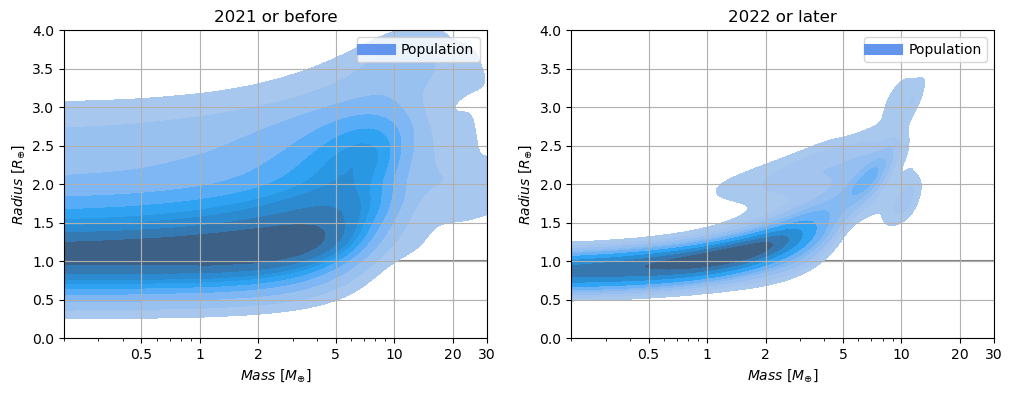

In [10]:
EA_planets = filter_planets_2021less(planet_name_EA,"M")
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low,disc_year = make_lists(EA_planets)

num_samples = 30
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

radii = []; masses = []; densitys = []
for i in range(0,len(mass)):
        mean_mass = mass[i]; mass_lower_err = np.abs(mass_low[i]);  mass_upper_err = mass_up[i]
        
        mean_density = np.divide(density,earth_density)[i]; 
        density_lower_err = np.divide(np.abs(density_low[i]),earth_density);  
        density_upper_err = np.divide(density_up,earth_density)[i]

        mean_radius = radius[i]
        radius_lower_err = np.abs(radius_low[i])
        radius_upper_err = radius_up[i]
        
        # Number of posterior samples to generate
        mass_samples = np.random.normal(mean_mass, (mass_lower_err + mass_upper_err) / 2, num_samples)
        masses.append(mass_samples)
        
        density_samples = np.random.normal(mean_density, (density_lower_err + density_upper_err) / 2, num_samples)
        densitys.append(density_samples)

        radius_samples = np.random.normal(mean_radius, (radius_lower_err + radius_upper_err) / 2, num_samples)
        radii.append(radius_samples)
        
masses_flattened = [item for sublist in masses for item in sublist]
radii_flattened = [item for sublist in radii for item in sublist]
densitys_flattened = [item for sublist in densitys for item in sublist]

# Create a 2D density colormap plot using KDE
sns.kdeplot(x =masses_flattened,y=radii_flattened, fill=True)
plt.plot(100,100,label="Population",color = "cornflowerblue")
mass_err         = [np.abs(mass_low),mass_up]
density_err      = [np.divide(np.abs(density_low),earth_density),np.divide(density_up,earth_density)]

#plt.plot(mass,np.divide(density,earth_density),".",label = "Planets",color = "0.4",markersize = 13,zorder=10)
#plt.errorbar(mass,np.divide(density,earth_density),xerr = mass_err, yerr = density_err,fmt=".",color="0.8",zorder=1)
plt.title('2021 or before')
plt.xlabel("$Mass\ [M_{\oplus}]$"); plt.ylabel("$Radius\ [R_{\oplus}]$"); plt.xscale("log");
plt.ylim(0,4); plt.xlim(0.2,30); plt.xticks([0.5,1,2,5,10,20, 30],["0.5","1","2","5","10","20", "30"],minor=False); plt.grid(); plt.hlines(1,0,30,"grey",zorder = -30); 
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
        
print(len(mass))

plt.subplot(1, 2, 2)
EA_planets = filter_planets_2022(planet_name_EA,"M")
index,planet,radius,radius_up,radius_low,density,density_up,density_low,mass,mass_up,mass_low,disc_year = make_lists(EA_planets)

radii = []; masses = []; densitys = []
for i in range(0,len(mass)):
        mean_mass = mass[i]; mass_lower_err = np.abs(mass_low[i]);  mass_upper_err = mass_up[i]
        
        mean_density = np.divide(density,earth_density)[i]; 
        density_lower_err = np.divide(np.abs(density_low[i]),earth_density);  
        density_upper_err = np.divide(density_up,earth_density)[i]

        mean_radius = radius[i]
        radius_lower_err = np.abs(radius_low[i])
        radius_upper_err = radius_up[i]
        
        # Number of posterior samples to generate
        mass_samples = np.random.normal(mean_mass, (mass_lower_err + mass_upper_err) / 2, num_samples)
        masses.append(mass_samples)
        
        density_samples = np.random.normal(mean_density, (density_lower_err + density_upper_err) / 2, num_samples)
        densitys.append(density_samples)

        radius_samples = np.random.normal(mean_radius, (radius_lower_err + radius_upper_err) / 2, num_samples)
        radii.append(radius_samples)
        

masses_flattened = [item for sublist in masses for item in sublist]
radii_flattened = [item for sublist in radii for item in sublist]
densitys_flattened = [item for sublist in densitys for item in sublist]

# Create a 2D density colormap plot using KDE
sns.kdeplot(x =masses_flattened,y=radii_flattened, fill=True)
plt.plot(100,100,label="Population",color = "cornflowerblue")
mass_err         = [np.abs(mass_low),mass_up]
density_err      = [np.divide(np.abs(density_low),earth_density),np.divide(density_up,earth_density)]

#plt.plot(mass,np.divide(density,earth_density),".",label = "Planets",color = "0.4",markersize = 13,zorder=10)
#plt.errorbar(mass,np.divide(density,earth_density),xerr = mass_err, yerr = density_err,fmt=".",color="0.8",zorder=1)
plt.title('2022 or later')
plt.xlabel("$Mass\ [M_{\oplus}]$"); plt.ylabel("$Radius\ [R_{\oplus}]$"); plt.xscale("log");
plt.ylim(0,4); plt.xlim(0.2,30); plt.xticks([0.5,1,2,5,10,20, 30],["0.5","1","2","5","10","20", "30"],minor=False); plt.grid(); plt.hlines(1,0,30,"grey",zorder = -30); 
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
    
print(len(mass))